# Chapter 12: Estimation of Linear Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

In [2]:
MASchools = pd.read_csv("../data/MASchools.csv")

In [12]:
df = MASchools.iloc[:, [12, 6,7,8,10,14]].copy()
print(df.shape)
df.head(7).round(2)

(220, 6)


,score4,exptot,scratio,special,stratio,salary
0,714,4646,16.6,14.6,19.0,34.36
1,731,4930,5.7,17.4,22.6,38.06
2,704,4281,7.5,12.1,19.3,32.49
3,704,4826,8.6,21.1,17.9,33.11
4,701,4824,6.1,16.8,17.5,34.44
5,714,6454,7.7,17.2,15.7,NaN
6,725,5537,5.4,11.3,17.1,41.62


In [13]:
df.isna().mean()*100

score4      0.000000
exptot      0.000000
scratio     4.090909
special     0.000000
stratio     0.000000
salary     11.363636
dtype: float64

In [14]:
num_na = df.isna().any(axis=1).sum() # no of rows with any NAs 
num_complete = len(df) - num_na # complement
print("True: ",num_na, "False: ", num_complete)

True:  34 False:  186


In [15]:
salarymean = df['salary'].mean()
salaryimputed = df['salary'].fillna(salarymean)
print(salarymean)
print(salaryimputed.mean())
print(df['salary'].std())
print(salaryimputed.std())

35.992697446774216
35.99269744677423
3.1905555712426232
3.0029293928495764


In [49]:
df1 = df.dropna().copy() # copy is needed to make future assignments safe
print(len(df))
len(df1)

220


186

## Baseline Model

In [26]:
# diectly using numeric optimization
def LLnorm(params):
    p = scipy.stats.norm(params[0], params[1]).pdf(df1['score4'])
    LL = np.sum(np.log(p))
    return(-1*LL)
res1 = scipy.optimize.minimize(LLnorm, x0 = [700,50], method='Nelder-Mead')
print(res1)

 final_simplex: (array([[709.03761985,  15.39565008],
       [709.03770308,  15.39563556],
       [709.03768281,  15.39557791]]), array([772.46215251, 772.46215251, 772.46215251]))
           fun: 772.4621525059797
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 64
        status: 0
       success: True
             x: array([709.03761985,  15.39565008])


In [28]:
# using the statsmodels class framework
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats

class myMLEbase(GenericLikelihoodModel):
    def loglike(self, params):
        return stats.norm.logpdf(self.endog,loc=params[0],scale=params[1]).sum() 

exog = pd.DataFrame(np.ones([len(df1),2]),columns=['mean','std'],index=df1.index) 
endog = df1[['score4']] # target

mybase = myMLEbase(endog,exog) # setup
print((mybase.fit(start_params=[700, 50],maxiter=2000)).summary())

Optimization terminated successfully.
         Current function value: 4.153022
         Iterations: 64
         Function evaluations: 126
                              myMLEbase Results                               
Dep. Variable:                 score4   Log-Likelihood:                -772.46
Model:                      myMLEbase   AIC:                             1547.
Method:            Maximum Likelihood   BIC:                             1550.
Date:                Sun, 21 Aug 2022                                         
Time:                        15:13:21                                         
No. Observations:                 186                                         
Df Residuals:                     185                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

/Users/tweyde/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/tweyde/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


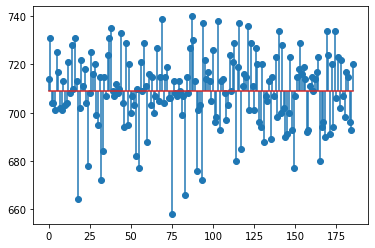

In [29]:
plt.stem(df1['score4']-709) # plot difference from baseline
ticks = np.arange(-49,40,20) # ticks from 660-baseline 
plt.yticks(ticks=ticks,labels=ticks+709) # show full values
plt.show()

In [33]:
SST = np.sum((df1['score4'] - 709)**2)
SST

44087

## Linear Regression Model

In [31]:
# using statsmodels GenericLikelihoodModel
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats
import statsmodels.api as sm

class myMLE(GenericLikelihoodModel):
    def loglike(self, params):
        stddev = params[-1] # separate treatment for the stddev
        mean1 = self.exog.dot(params[:-1]) # 
        return stats.norm.logpdf(self.endog,loc=mean1,scale=stddev).sum() # ll 

exog = df1[['exptot','scratio','special','stratio','salary']]
exog = sm.add_constant(exog, prepend=True) # add intercept
print(exog.head())
endog = df1[['score4']] # target

myreg = myMLE(endog,exog) # setup
myreg.exog_names.append('stddev') # add stddev param
start_params = [709, 0, 0, 0, 0, 0, 15.4] # need start vals in right size
res = myreg.fit(start_params=start_params,maxiter=2000,method='nm') #need many iters
print(res.summary())

   const  exptot  scratio    special    stratio     salary
0    1.0    4646     16.6  14.600000  19.000000  34.360001
1    1.0    4930      5.7  17.400000  22.600000  38.063000
2    1.0    4281      7.5  12.100000  19.299999  32.491001
3    1.0    4826      8.6  21.100000  17.900000  33.105999
4    1.0    4824      6.1  16.799999  17.500000  34.436501
Optimization terminated successfully.
         Current function value: 3.991881
         Iterations: 1343
         Function evaluations: 2034
                                myMLE Results                                 
Dep. Variable:                 score4   Log-Likelihood:                -742.49
Model:                          myMLE   AIC:                             1497.
Method:            Maximum Likelihood   BIC:                             1516.
Date:                Sun, 21 Aug 2022                                         
Time:                        15:26:17                                         
No. Observations:             

/Users/tweyde/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/tweyde/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [38]:
# using statsmodels glm from formula class
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = "score4 ~ exptot + scratio + special + stratio + salary"
mod1 = smf.glm(formula=formula, data=df1, family=sm.families.Gaussian()).fit()
print(mod1.summary())
pred = np.array(mod1.predict(df1)).reshape(-1,1)
resid = pred-df1[['score4']]

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 score4   No. Observations:                  186
Model:                            GLM   Df Residuals:                      180
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          177.45
Method:                          IRLS   Log-Likelihood:                -742.49
Date:                Sun, 21 Aug 2022   Deviance:                       31941.
Time:                        15:31:05   Pearson chi2:                 3.19e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3083
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    714.7035     16.343     43.730      0.0

In [39]:
# using numeric optimization
def LLnorm(params):
    b0, b1, b2, b3, b4, b5, standdev = params
    mean1 = b0 + b1*df1['exptot'] + b2*df1['scratio'] + b3*df1['special'] + b4*df1['stratio'] + b5*df1['salary']
    p = scipy.stats.norm(mean1, standdev).pdf(df1['score4'])
    LL = np.sum(np.log(p))
    return(-1*LL)

res2 = scipy.optimize.minimize(LLnorm, x0 = [709, 0, 0, 0, 0, 0, 15.4], 
                               method = 'Nelder-Mead', options={'maxiter':2000})
#from pprint import pprint
#['final_simplex', 'fun', 'message', 'nfev', 'nit', 'status', 'success', 'x']
res2

 final_simplex: (array([[ 7.14703557e+02, -5.02906439e-03, -1.07875748e-01,
        -7.16282665e-01, -2.64688018e+00,  2.21067219e+00,
         1.31043293e+01],
       [ 7.14703497e+02, -5.02906333e-03, -1.07873831e-01,
        -7.16281899e-01, -2.64687967e+00,  2.21067273e+00,
         1.31043314e+01],
       [ 7.14703514e+02, -5.02906002e-03, -1.07875143e-01,
        -7.16282491e-01, -2.64687821e+00,  2.21067173e+00,
         1.31043311e+01],
       [ 7.14703511e+02, -5.02905158e-03, -1.07875102e-01,
        -7.16283221e-01, -2.64687738e+00,  2.21067037e+00,
         1.31043301e+01],
       [ 7.14703581e+02, -5.02905840e-03, -1.07874494e-01,
        -7.16283238e-01, -2.64687977e+00,  2.21067039e+00,
         1.31043310e+01],
       [ 7.14703612e+02, -5.02905935e-03, -1.07874652e-01,
        -7.16283145e-01, -2.64688067e+00,  2.21067024e+00,
         1.31043316e+01],
       [ 7.14703554e+02, -5.02905387e-03, -1.07876596e-01,
        -7.16281477e-01, -2.64687867e+00,  2.21066962e+00,
 

## Regression Equations

In [42]:
res2.x

array([ 7.14703557e+02, -5.02906439e-03, -1.07875748e-01, -7.16282665e-01,
       -2.64688018e+00,  2.21067219e+00,  1.31043293e+01])

In [61]:
df1['baseline'] = 709
df1['regression'] = df1[['exptot','scratio','special','stratio','salary']].dot(res2.x[1:6]) \
         + res2.x[0]
df1['regerror'] = df1['score4'] - df1['regression']
print(df1.head().round(3).iloc[:, [0,6,7,8]])

   score4  baseline  regression  regerror
0     714       709     704.758     9.242
1     731       709     701.157    29.843
2     704       709     704.440    -0.440
3     704       709     700.199     3.801
4     701       709     707.559    -6.559


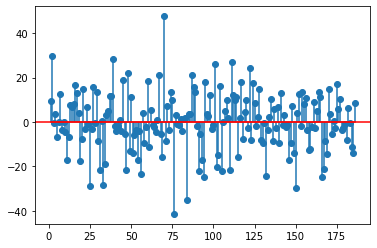

In [64]:
x = np.arange(1, len(df1)+1)
plt.stem(x, df1['regerror'])
plt.axhline(0, color='red')
plt.show()

In [71]:
SSE = np.sum((df1['regression'] - df1['score4'])**2)
round(SSE,2)

31940.564

In [72]:
Rsquare = 1 - (SSE/SST)
round(Rsquare,3)

0.276

In [75]:
varbaseline = 15.39563**2
varregression = 13.1042240**2
round(1 - (varregression/varbaseline),3)

0.276

### Statistical Significance

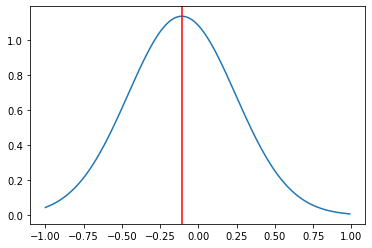

array([-1.95996398,  1.95996398])

In [92]:
m1 = -0.1083852
se1 = 0.3516757
x = np.arange(-1, 1, 0.01)
p = scipy.stats.norm(m1, se1).pdf(x)
plt.plot(x, p)
plt.axvline(m1, color='red')
plt.show()
stats.norm.ppf([.05/2,1-.05/2])

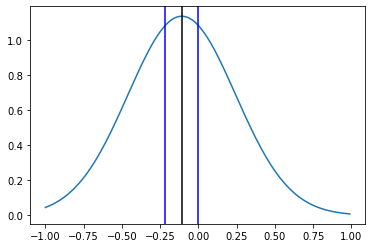

0.757933

In [93]:
gap = abs(m1 - 0)
x = np.arange(-1, 1, 0.01)
p = scipy.stats.norm(m1, se1).pdf(x)
plt.plot(x, p)
plt.axvline(m1, color='black')
plt.axvline(m1 - gap, color='blue')
plt.axvline(m1 + gap, color='blue')
plt.show()
a = scipy.stats.norm(m1, se1).cdf(m1 + gap)
b = scipy.stats.norm(m1, se1).cdf(m1 - gap)
pval1 = 1 - (a - b)
round((pval1),6)

### Assumptions of the Regression Model

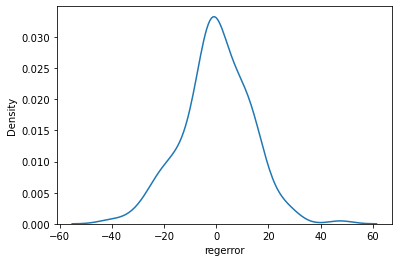

ShapiroResult(statistic=0.9886723160743713, pvalue=0.14497749507427216)


In [95]:
sns.kdeplot(df1['regerror'])
plt.show()
shapiro = scipy.stats.shapiro(df1['regerror'])
print(shapiro)

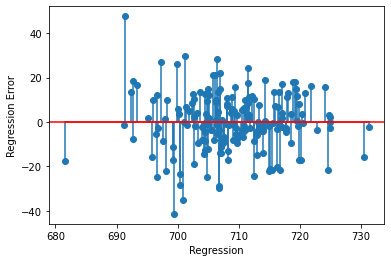

In [96]:
plt.stem(df1['regression'], df1['regerror'])
plt.axhline(0, color='red')
plt.xlabel('Regression')
plt.ylabel('Regression Error')
plt.show()

### Regression Functions in R and Python

In [104]:
from statsmodels.formula.api import ols
res3 = ols("score4 ~ exptot + scratio + special + stratio + salary", data=df1).fit()
print(res3.summary())
import statsmodels.formula.api as smf
import statsmodels.api as sm
#res4 = smf.glm("score4 ~ exptot + scratio + special + stratio + salary", data=df1, family=sm.families.Gaussian()).fit()
#print(res4.summary())

                            OLS Regression Results                            
Dep. Variable:                 score4   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     13.69
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           2.50e-11
Time:                        16:27:19   Log-Likelihood:                -742.49
No. Observations:                 186   AIC:                             1497.
Df Residuals:                     180   BIC:                             1516.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    714.7035     16.343     43.730      0.0